In [1]:
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
def WFD_healpixels(nside=None, dec_min=-60., dec_max=0.):
    """
    Define a wide fast deep region. Return a healpix map with WFD pixels as 1.
    """
    if nside is None:
        nside = set_default_nside()

    ra, dec = ra_dec_hp_map(nside=nside)
    result = np.zeros(ra.size)
    good = np.where((dec >= np.radians(dec_min)) & (dec <= np.radians(dec_max)))
    result[good] += 1
    return result

In [3]:
def SCP_healpixels(nside=None, dec_max=-60.):
    """
    Define the South Celestial Pole region. Return a healpix map with SCP pixels as 1.
    """
    if nside is None:
        nside = set_default_nside()

    ra, dec = ra_dec_hp_map(nside=nside)
    result = np.zeros(ra.size)
    good = np.where(dec < np.radians(dec_max))
    result[good] += 1
    return result


def NES_healpixels(nside=None, min_EB=-30.0, max_EB = 10.0, dec_min=2.8):
    """
    Define the North Ecliptic Spur region. Return a healpix map with NES pixels as 1.

    Parameters
    ----------
    nside : int
        A valid healpix nside
    min_EB : float (-30.)
        Minimum barycentric true ecliptic latitude (deg)
    max_EB : float (10.)
        Maximum barycentric true ecliptic latitude (deg)
    dec_min : float (2.8)
        Minimum dec in degrees

    Returns
    -------
    result : numpy array
    """
    if nside is None:
        nside = set_default_nside()

    ra, dec = ra_dec_hp_map(nside=nside)
    result = np.zeros(ra.size)
    coord = SkyCoord(ra=ra*u.rad, dec=dec*u.rad)
    eclip_lat = coord.barycentrictrueecliptic.lat.radian
    good = np.where((eclip_lat > np.radians(min_EB)) &
                    (eclip_lat < np.radians(max_EB)) &
                    (dec > np.radians(dec_min)))
    result[good] += 1

    return result


In [4]:
def galactic_plane_healpixels(nside=None, center_width=10., end_width=4.,
                              gal_long1=70., gal_long2=290.):
    """
    Define the Galactic Plane region. Return a healpix map with GP pixels as 1.
    """
    if nside is None:
        nside = set_default_nside()

    ra, dec = ra_dec_hp_map(nside=nside)
    result = np.zeros(ra.size)
    coord = SkyCoord(ra=ra*u.rad, dec=dec*u.rad)
    g_long, g_lat = coord.galactic.l.radian, coord.galactic.b.radian
    good = np.where((g_long < np.radians(gal_long1)) & (np.abs(g_lat) < np.radians(center_width)))
    result[good] += 1
    good = np.where((g_long > np.radians(gal_long2)) & (np.abs(g_lat) < np.radians(center_width)))
    result[good] += 1
    # Add tapers
    slope = -(np.radians(center_width)-np.radians(end_width))/(np.radians(gal_long1))
    lat_limit = slope*g_long+np.radians(center_width)
    outside = np.where((g_long < np.radians(gal_long1)) & (np.abs(g_lat) > np.abs(lat_limit)))
    result[outside] = 0
    slope = (np.radians(center_width)-np.radians(end_width))/(np.radians(360. - gal_long2))
    b = np.radians(center_width)-np.radians(360.)*slope
    lat_limit = slope*g_long+b
    outside = np.where((g_long > np.radians(gal_long2)) & (np.abs(g_lat) > np.abs(lat_limit)))
    result[outside] = 0

    return result

In [5]:
def generate_goal_map(nside=None, NES_fraction = .3, WFD_fraction = 1., SCP_fraction=0.4,
                      GP_fraction = 0.2, WFD_upper_edge_fraction = 0.25,
                      NES_min_EB = -30., NES_max_EB = 10, NES_dec_min = 3.6,
                      SCP_dec_max=-62.5, gp_center_width=10.,
                      gp_end_width=4., gp_long1=70., gp_long2=290.,
                      wfd_dec_min=-62.5, wfd_dec_max=3.6,
                      generate_id_map=False):
    """
    Handy function that will put together a target map in the proper order.
    """
    if nside is None:
        nside = set_default_nside()

    # Note, some regions overlap, thus order regions are added is important.
    result = np.zeros(hp.nside2npix(nside), dtype=float)
    id_map = np.zeros(hp.nside2npix(nside), dtype=int)
    pid = 1
    prop_name_dict = dict()

    if WFD_upper_edge_fraction > 0.:
        wfd_upper_edge = WFD_upper_edge_healpixels(nside=nside, dec_min=wfd_dec_max)
        result[np.where(wfd_upper_edge != 0)] = 0
        result += WFD_upper_edge_fraction*wfd_upper_edge
        id_map[np.where(wfd_upper_edge != 0)] = 3
        pid += 1
        prop_name_dict[3] = 'WideFastDeep'

    if NES_fraction > 0.:
        nes = NES_healpixels(nside=nside, min_EB = NES_min_EB, max_EB = NES_max_EB,
                             dec_min=NES_dec_min)
        result[np.where(nes != 0)] = 0
        result += NES_fraction*nes
        id_map[np.where(nes != 0)] = 1
        pid += 1
        prop_name_dict[1] = 'NorthEclipticSpur'

    if WFD_fraction > 0.:
        wfd = WFD_healpixels(nside=nside, dec_min=wfd_dec_min, dec_max=wfd_dec_max)
        result[np.where(wfd != 0)] = 0
        result += WFD_fraction*wfd
        id_map[np.where(wfd != 0)] = 3
        pid += 1
        prop_name_dict[3] = 'WideFastDeep'

    if SCP_fraction > 0.:
        scp = SCP_healpixels(nside=nside, dec_max=SCP_dec_max)
        result[np.where(scp != 0)] = 0
        result += SCP_fraction*scp
        id_map[np.where(scp != 0)] = 2
        pid += 1
        prop_name_dict[2] = 'SouthCelestialPole'

    if GP_fraction > 0.:
        gp = galactic_plane_healpixels(nside=nside, center_width=gp_center_width,
                                       end_width=gp_end_width, gal_long1=gp_long1,
                                       gal_long2=gp_long2)
        result[np.where(gp != 0)] = 0
        result += GP_fraction*gp
        id_map[np.where(gp != 0)] = 4
        pid += 1
        prop_name_dict[4] = 'GalacticPlane'

    if generate_id_map:
        return result, id_map, prop_name_dict
    else:
        return result


In [6]:
def standard_goals(nside=None):
    """
    A quick function to generate the "standard" goal maps.
    """
    # Find the number of healpixels we expect to observe per observation
    if nside is None:
        nside = set_default_nside()

    result = {}
    result['u'] = generate_goal_map(nside=nside, NES_fraction=0.,
                                    WFD_fraction=0.31, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['g'] = generate_goal_map(nside=nside, NES_fraction=0.2,
                                    WFD_fraction=0.44, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['r'] = generate_goal_map(nside=nside, NES_fraction=0.46,
                                    WFD_fraction=1.0, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['i'] = generate_goal_map(nside=nside, NES_fraction=0.46,
                                    WFD_fraction=1.0, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['z'] = generate_goal_map(nside=nside, NES_fraction=0.4,
                                    WFD_fraction=0.9, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['y'] = generate_goal_map(nside=nside, NES_fraction=0.,
                                    WFD_fraction=0.9, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)

    return result


In [7]:
def _hpid2RaDec(nside, hpids):
    """
    Correct for healpy being silly and running dec from 0-180.

    Parameters
    ----------
    nside : int
        Must be a value of 2^N.
    hpids : np.array
        Array (or single value) of healpixel IDs.

    Returns
    -------
    raRet : float (or np.array)
        RA positions of the input healpixel IDs. In radians.
    decRet : float (or np.array)
        Dec positions of the input healpixel IDs. In radians.
    """

    lat, lon = hp.pix2ang(nside, hpids)
    decRet = np.pi / 2.0 - lat
    raRet = lon

    return raRet, decRet


In [8]:

def ra_dec_hp_map(nside=None):
    """
    Return all the RA,dec points for the centers of a healpix map
    """
    if nside is None:
        nside = set_default_nside()

    ra, dec = _hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
    return ra, dec

In [9]:
footprints = standard_goals(nside=64)

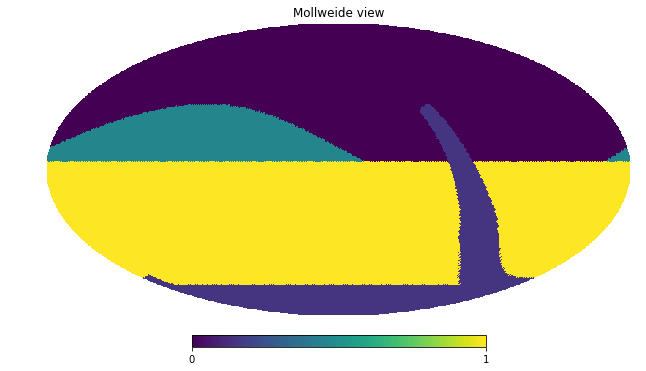

In [10]:
hp.mollview(footprints['r'])